# Getting started with packages imports and git repo cloning

* https://github.com/BojarLab/SweetNet/blob/main/SweetNet_code.ipynb
* https://medium.com/mantisnlp/how-to-combine-several-embeddings-models-8e7bc9a00330
* https://distill.pub/2021/gnn-intro/
* https://bojarlab.github.io/glycowork/glycan_data.html
* https://www.sciencedirect.com/science/article/pii/S2211124721006161#sec1
* https://academic.oup.com/glycob/article/31/10/1240/6311240#312815562

In [1]:
!git clone -b phi https://github.com/PhiCtl/isospec-internship/

Cloning into 'isospec-internship'...
remote: Enumerating objects: 312, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 312 (delta 52), reused 67 (delta 33), pack-reused 200 (from 1)
Receiving objects: 100% (312/312), 33.01 MiB | 6.11 MiB/s, done.
Resolving deltas: 100% (118/118), done.


In [ ]:
!pip install "glycowork[ml]" nbdev glycowork

In [3]:
import warnings
warnings.filterwarnings("ignore")
from IPython.display import HTML
from nbdev.showdoc import show_doc

import numpy as np
import pandas as pd
import os
import copy
import matplotlib.pyplot as plt
import seaborn as sns

import torch

from glycowork.ml.models import *
from glycowork.ml.inference import *
from glycowork.ml.processing import *
from glycowork.ml.model_training import *
from glycowork.ml.train_test_split import *
from glycowork.glycan_data.loader import df_species, df_glycan, glycan_binding
from glycowork.glycan_data.loader import *

In [46]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import cdist

In [5]:
import copy

In [6]:
DATA_PATH = "/content/isospec-internship/data/glycan_embedding"

# Datasets

In [7]:
# Extracted glycans used for inference and enrichment
df_glycan_list = pd.read_csv(os.path.join(DATA_PATH, 'glycan_list.csv')).rename(columns={'tissue_species': 'Species'})
df_glycan_list['type'] = 'unknown'
df_glycan_list.head()

,glycan,Composition,Species,tissue_sample,type
0,Fuc(a1-?)GlcNAc(b1-2)Man(a1-6)[GlcNAc(b1-2)Man...,"{'dHex': 2, 'HexNAc': 4, 'Hex': 3}",['Homo_sapiens'],['blood'],unknown
1,Neu5Ac(a2-?)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Glc...,"{'Neu5Ac': 1, 'Hex': 4, 'HexNAc': 4, 'dHex': 1}",['Homo_sapiens'],['blood'],unknown
2,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Gal...,"{'Neu5Ac': 1, 'Hex': 5, 'HexNAc': 4}",['Homo_sapiens'],['blood'],unknown
3,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Glc...,"{'Neu5Ac': 1, 'Hex': 4, 'HexNAc': 4}",['Homo_sapiens'],['blood'],unknown
4,Fuc(a1-2)[GalNAc(a1-3)]Gal(b1-4)GlcNAc(b1-2)Ma...,"{'dHex': 1, 'HexNAc': 5, 'Hex': 5}",['Homo_sapiens'],['blood'],unknown


In [8]:
# Curated list for inference
df_glycan = df_glycan[~df_glycan['glycan'].isin(df_glycan_list['glycan'].to_list())] # Remove glycans of interest from the curated list...
df_glycan.shape

(50589, 23)

In [9]:
print(f"There are {df_glycan.explode('Species')['Species'].nunique()} unique species in the data set",
         f"and {df_glycan.explode('disease_association')['disease_association'].dropna().nunique()-1} diseases.")

There are 2793 unique species in the data set and 59 diseases.


In [10]:
glycan_binding.head()

,3-Anhydro-Gal(a1-3)Gal(b1-4)3-Anhydro-Gal(a1-3)Gal4S,3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S,3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S,3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S,3-Anhydro-Gal(a1-3)Gal4S(b1-4)3-Anhydro-Gal2S(a1-3)Gal4S(b1-4)3-Anhydro-Gal(a1-3)Gal4S,3dGal(b1-3)[Fuc(a1-4)]Glc,3dGal(b1-4)Glc,4d8dNeu5Ac(a2-3)Gal(b1-4)Glc,4dNeu5Ac(a2-3)Gal(b1-4)Glc,7dNeu5Ac(a2-3)Gal(b1-4)Glc,...,wwwSflexneri5c,wwwSflexneriO2c,wwwSflexneriO5c,wwwSisomicin,wwwSmix,wwwTobramycin,wwwTyrS,wwwpHGGs,target,protein
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AADSIPSISPTGIITPTPTQSGMVSNCNKFYDVHSNDGCSAIASSQ...,TAL6-4LysM
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AAFFSLVVLLALLPFGIHASALPSTELTPRVNPNLPGPNDVFVGFR...,rCnSL-proA
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AANEADYQAKLTAYQTELARVQKANADAKAAYEAAVAANNAANAAL...,AntigenI/IIA3VP1
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,AASKLGVPQPAQRDQVNCQLYAVQPNDNCIDISSKNNITYAQLLSW...,TAL6-6LysM
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ACNNEWEDEQYEQYISFKSPIPAGGEGVTDIYVRYKEDGKVTYRLP...,SP15308A-bot-339-19-339


In [11]:
# Used to control representation in the embedding space by assessing closeness
df_N_glycans = pd.read_csv(os.path.join(DATA_PATH, 'N_glycans_df.csv'))
df_N_glycans['type'] = 'N_glycans'

# N glycans are present within df_glycan df
res = pd.merge(df_N_glycans, df_glycan, on='glycan', how='left', indicator =True)
res = res[res['_merge'] == 'left_only'].drop('_merge', axis=1)
print(res)

Empty DataFrame
Columns: [glycan, Species_x, Genus_x, Family_x, Order_x, Class_x, Phylum_x, Kingdom_x, Domain_x, ref_x, glytoucan_id_x, glycan_type_x, disease_association_x, disease_id_x, disease_sample_x, disease_direction_x, disease_ref_x, disease_species_x, tissue_sample_x, tissue_id_x, tissue_ref_x, tissue_species_x, Composition_x, Structure_Type, type, Species_y, Genus_y, Family_y, Order_y, Class_y, Phylum_y, Kingdom_y, Domain_y, ref_y, glytoucan_id_y, glycan_type_y, disease_association_y, disease_id_y, disease_sample_y, disease_direction_y, disease_ref_y, disease_species_y, tissue_sample_y, tissue_id_y, tissue_ref_y, tissue_species_y, Composition_y]
Index: []

[0 rows x 47 columns]


# 1 - Approaches reflexion

Getting inspiration from [Using graph convolutional neural networks to learn a representation for glycans](https://www.sciencedirect.com/science/article/pii/S2211124721006161#sec1) :
* Sweetnet is a graph convolutional network (GCNN) that provides a useful glycan representation using glycan sequences.
* Sweetnet was trained using _the task of predicting which species a given glycan sequence came from_, ie. a multiclass classification task for a better model performance comparison. The GCNN approach outperformed existing approaches on the classification task. See more about Sweetnet training [here](https://github.com/BojarLab/SweetNet/blob/main/SweetNet_code.ipynb).
* Sweetnet was also pretrained using _a context prediction task in which the model is used to predict the identity of a randomly chosen hidden node, given the connectivities and the other nodes in a glycan_ before being fine-tuned on the classification task.

The state of the art embedding for glycans from different species is already computed by Sweetnet graph. Using graph neural networks seems the best possible approach. Nevertheless, different approaches for embedding can be used:
* Take advantage of curated Sweetnet GCNN architecture for glycan sequence embedding, train the model on all glycans sequences with the task of predicting the species. ``` composition ``` and ```tissue_sample``` features could be leveraged for embedding space learning as well, but 1) ```composition``` is redundant with the glycan sequence and 2) ```tissue_sample``` might not exactly reflect glycan presence in tissues.
* Same task as above predicting the glycan type (eg. N, O, etc...).
* Explore another type of graph neural network architecture, namely graph transformers ([See HugginFace website](https://huggingface.co/docs/transformers/en/model_doc/graphormer#usage-tips)).



# 2- Using Sweetnet trained on species classification for properties inference

Multi class classification, ie. each glycan can belong to several species.

## 2.1 data processing

In [12]:
df_data = df_glycan.explode('Species')
df_data = df_data.drop_duplicates(['Species', 'glycan'])

In [15]:
train_x, val_x, train_y, val_y, id_val, class_list, class_converter = hierarchy_filter(df_data,
                                                                              rank = 'Species', min_seq=10)

In [16]:
print(f"{len(train_x)} glycans and {class_list} classes")

24063 glycans and ['Abelmoschus_esculentus', 'Acanthocheilonema_viteae', 'Acer_pseudoplatanus', 'Acidomonas_methanolica', 'Acinetobacter_baumannii', 'Acinetobacter_haemolyticus', 'Acinetobacter_sp', 'Acremonium_sp', 'Actinidia_chinensis', 'Actinobacillus_pleuropneumoniae', 'Adeno-associated_dependoparvovirusA', 'Aedes_aegypti', 'Aepyceros_melampus', 'Aeromonas_hydrophila', 'Aeromonas_salmonicida', 'Agaricus_bisporus', 'Agaricus_blazei', 'Aggregatibacter_actinomycetemcomitans', 'Agrobacterium_rubi', 'Agrobacterium_tumefaciens', 'Ailuropoda_melanoleuca', 'Alces_alces', 'Allium_cepa', 'Allochrocebus_lhoesti', 'Amblyomma_americanum', 'Ambystoma_maculatum', 'Ambystoma_tigrinum', 'Amorphophallus_konjac', 'Anagallis_arvensis', 'Anas_platyrhynchos', 'Anas_sp', 'Androctonus_australis_hector', 'Aneurinibacillus_thermoaerophilus', 'Angiostrongylus_cantonensis', 'Anopheles_gambiae', 'Apis_mellifera', 'Apium_graveolens_dulce', 'Aplysia_kurodai', 'Apostichopus_californicus', 'Arabidopsis_thaliana', 

## 2.2 Model training

### 2.2.1 Actually training the model

Epoch 0/99
----------
train Loss: 5.8980 Accuracy: 0.1819 MCC: 0.0678
val Loss: 5.5897 Accuracy: 0.1975 MCC: 0.1070
Validation loss decreased (0.000000 --> 5.589661).  Saving model ...

Epoch 1/99
----------
train Loss: 5.5632 Accuracy: 0.1973 MCC: 0.1095
val Loss: 5.4114 Accuracy: 0.2021 MCC: 0.1174
Validation loss decreased (5.589661 --> 5.411353).  Saving model ...

Epoch 2/99
----------
train Loss: 5.4267 Accuracy: 0.1998 MCC: 0.1147
val Loss: 5.2737 Accuracy: 0.2040 MCC: 0.1237
Validation loss decreased (5.411353 --> 5.273658).  Saving model ...

Epoch 3/99
----------
train Loss: 5.3114 Accuracy: 0.2068 MCC: 0.1283
val Loss: 5.1836 Accuracy: 0.2174 MCC: 0.1432
Validation loss decreased (5.273658 --> 5.183638).  Saving model ...

Epoch 4/99
----------
train Loss: 5.2223 Accuracy: 0.2140 MCC: 0.1394
val Loss: 5.0995 Accuracy: 0.2194 MCC: 0.1484
Validation loss decreased (5.183638 --> 5.099508).  Saving model ...

Epoch 5/99
----------
train Loss: 5.1366 Accuracy: 0.2245 MCC: 0.1543


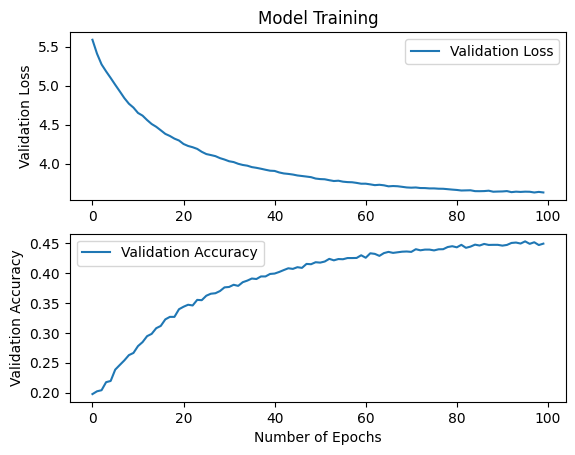

In [ ]:
dataloaders = split_data_to_train(train_x, val_x, train_y, val_y)
model = prep_model('SweetNet', trained=False, num_classes=len(class_list))
optimizer_ft, scheduler, criterion = training_setup(model, 0.0005, num_classes = len(class_list))
model_ft_3 = train_model(model, dataloaders, criterion, optimizer_ft, scheduler,
                   num_epochs = 100)

In [ ]:
torch.save(model_ft_3, '/content/SweetNet_species_10.pt')

### 2.2.2 Retrieving trained model weights

In [ ]:
model_ft_3 = torch.load('/content/isospec-internship/models/SweetNet_species_10.pt', map_location=torch.device('cpu'))
model_ft_3.eval()

## 2.3 Embedding visualisation

In [18]:
glycans = df_data.groupby('glycan').agg({'Composition': lambda x : x,\
                                         'Species': lambda x : list(x),
                                         'tissue_sample': lambda x :x})\
                                  .reset_index()\
                                  .merge(df_N_glycans[['glycan', 'type']], on='glycan', how='outer')\
                                  .fillna({'type' : 'known'})
glycans = pd.concat([glycans, df_glycan_list]).reset_index(drop=True)
glycans['from_human'] = glycans['Species'].apply(lambda ss : 'Human glycan' if 'Homo_sapiens' in ss\
                                                 else 'Non human glycan')

df_learned_rep = glycans_to_emb(glycans['glycan'].values, model_ft_3)

In [63]:
df_learned_rep_augm = df_learned_rep.merge(glycans, left_index=True, right_index=True)

### 2.3.1 Cluster visualisation

In [68]:
tsne_emb_1 = TSNE(random_state = 42).fit_transform(df_learned_rep_augm.drop([c for c in glycans.columns], axis=1))
#tsne_emb_1 = tsne_emb_1.merge(df_learned_rep_augm[c for c in glycans.columns], left_index=True, right_index=True)#.set_index('glycan')

In [71]:
tsne_emb_1 = pd.DataFrame(tsne_emb_1).merge(df_learned_rep_augm[[c for c in glycans.columns]], left_index=True, right_index=True)
tsne_emb_1.set_index('glycan', inplace=True)

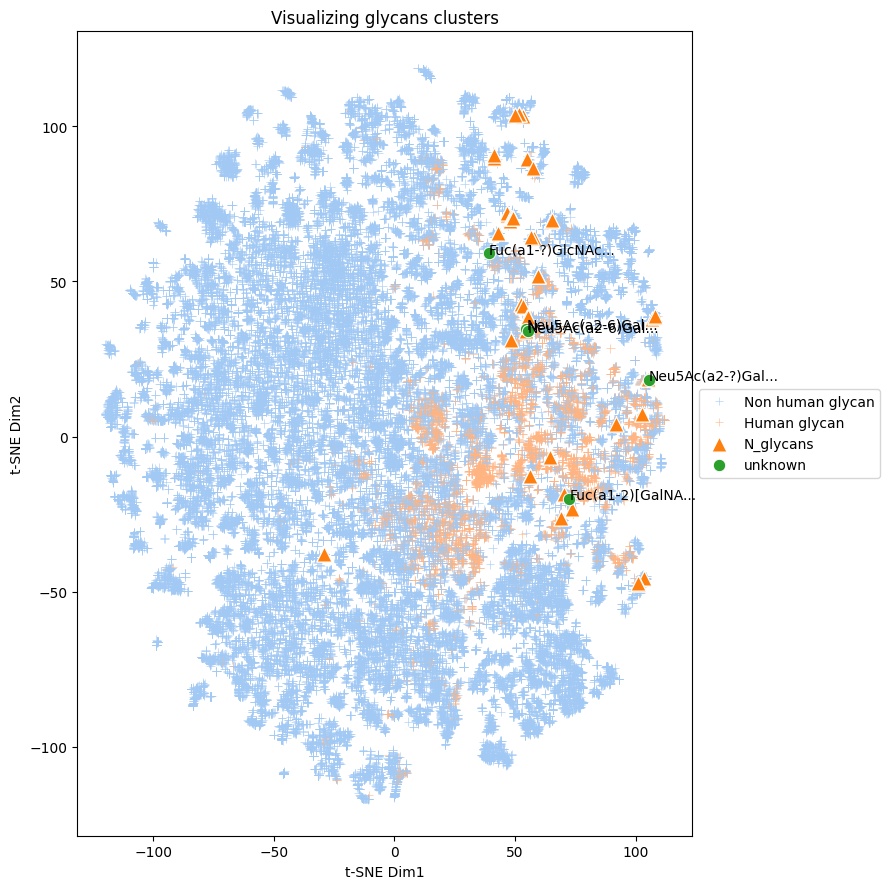

In [75]:
def plot_embedding_classes(df_embedding, embedding_type, visualization_hue='from_human'):

  assert((visualization_hue in df_embedding.columns) & ('type' in df_embedding.columns))

  plt.figure(figsize = (9, 9))
  sns.scatterplot(data = df_embedding[df_embedding['type'] == 'known'], x =0 , y = 1,\
              s = 40, alpha = 0.8, hue=visualization_hue,\
              marker='+', palette =sns.color_palette("pastel") )
  sns.scatterplot(data = df_embedding[df_embedding['type'] == 'N_glycans'], x =0 , y = 1,\
                  s = 120, alpha = 1,palette = ['red'],\
                  marker='^', label='N_glycans')
  fig = sns.scatterplot(data = df_embedding[df_embedding['type'] == 'unknown'], x =0 , y = 1,
                  s = 80, alpha = 1,\
                  palette = ['dark'], marker='o', label='unknown')

  for i, point in df_embedding.iterrows():
      if point['type'] == 'unknown':
          fig.text(point[0]+.02, point[1], str(i)[:15] + '...')

  plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
  plt.xlabel(f'{embedding_type} Dim1')
  plt.ylabel(f'{embedding_type} Dim2')
  plt.title('Visualizing glycans clusters')
  plt.tight_layout()

plot_embedding_classes(tsne_emb_1, 't-SNE', visualization_hue='from_human')

We can see from the cluster plot that N-linked glycans seem to cluster on the top right part of the graph, mostly on human glycan clusters. Our unknown glycans seem to belong to human glycans clusters.

PCA 1D clustering visualisation is not informative.

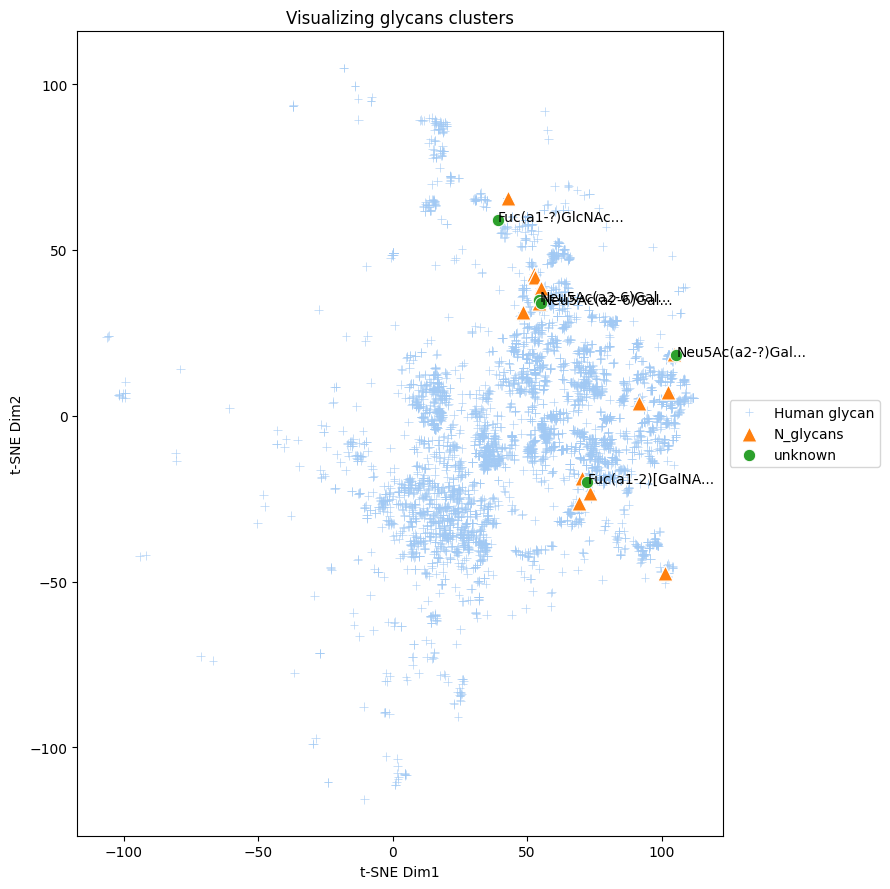

In [76]:
# Visualizing human glycans only
plot_embedding_classes(tsne_emb_1[tsne_emb_1['from_human'] == 'Human glycan'], 't-SNE', visualization_hue='from_human')

## 2.4 Enrich glycan information

The task is to find the most similar known glycans in the embedding space to the unknown glycans of interest.

Several approaches can be considered:
* Finding the most relevant neighbours. I search for a glycan neighbours as follow :
  * Find the point where curve slope change on the log scale and define the cluster boundary
  * define the cluster as all the points within the cluster boundary
  * This stage would need validation with other methods to see whether we end up with semantically consistent clusters around the points of interest.
* Clustering the data

I carefully chose the cosine distance or the Manhattan distance metrics as Euclidean distance metrics is not suited for high dimensions.


### 2.4.1 Finding relevant neighbours

In [153]:
df_reps = df_learned_rep_augm.set_index('glycan')\
          .drop(['type', 'tissue_sample', 'Species', 'Composition','from_human'], axis=1)\
          .T

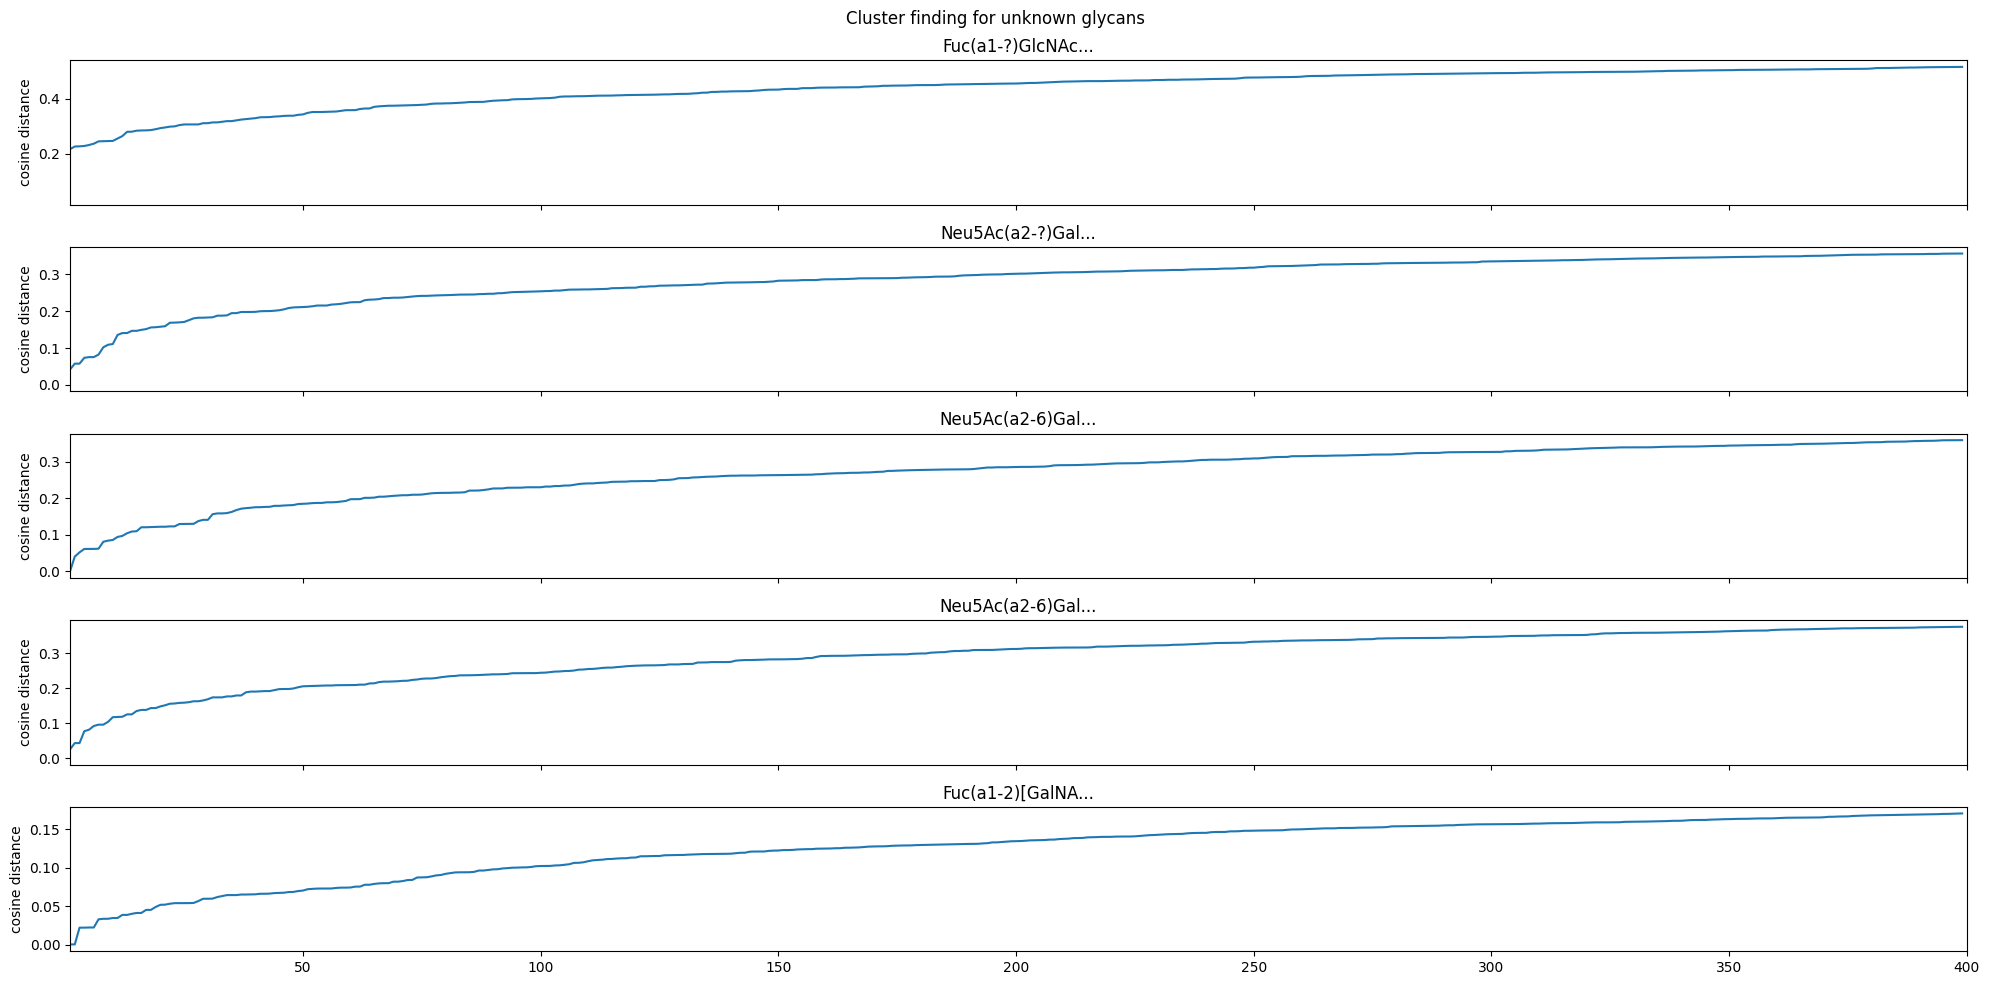

In [155]:
def plot_neighbours_distance(df_neighbours, glycans_list, metric='cosine',\
                             log_scale=False, max_dist=1000, n_closest=10):

  assert('glycan' in glycans_list.columns)
  assert(metric in ['cosine', 'cityblock'])

  neighbours_names = list(set(df_neighbours.columns) - set(glycans_list['glycan'].values))
  vecs = df_neighbours[neighbours_names].to_numpy()
  dists = { g : [] for g in glycans_list['glycan'].values}

  fig, axs = plt.subplots(nrows=glycans_list.shape[0], sharex=True, figsize=(20,10))

  for i, glycan in enumerate(glycans_list['glycan'].values):

    glyc_vec = np.expand_dims(df_neighbours[glycan].to_numpy(), axis=1)
    dist = cdist(glyc_vec.T, vecs.T, metric=metric).flatten()
    axs[i].plot(np.sort(dist)[:max_dist])
    axs[i].set(xlim=(1,max_dist))
    axs[i].set_title(glycan[:15] + '...')
    axs[i].set_ylabel(metric+ ' distance')
    if log_scale : axs[i].set_xscale('log')

    dists[glycan] = [ neighbours_names[i] for i in np.argsort(dist)[:n_closest]]

  plt.suptitle('Cluster finding for unknown glycans')
  plt.tight_layout()
  plt.show()

  return pd.DataFrame(dists)

_ = plot_neighbours_distance(df_reps, df_glycan_list, max_dist=400)

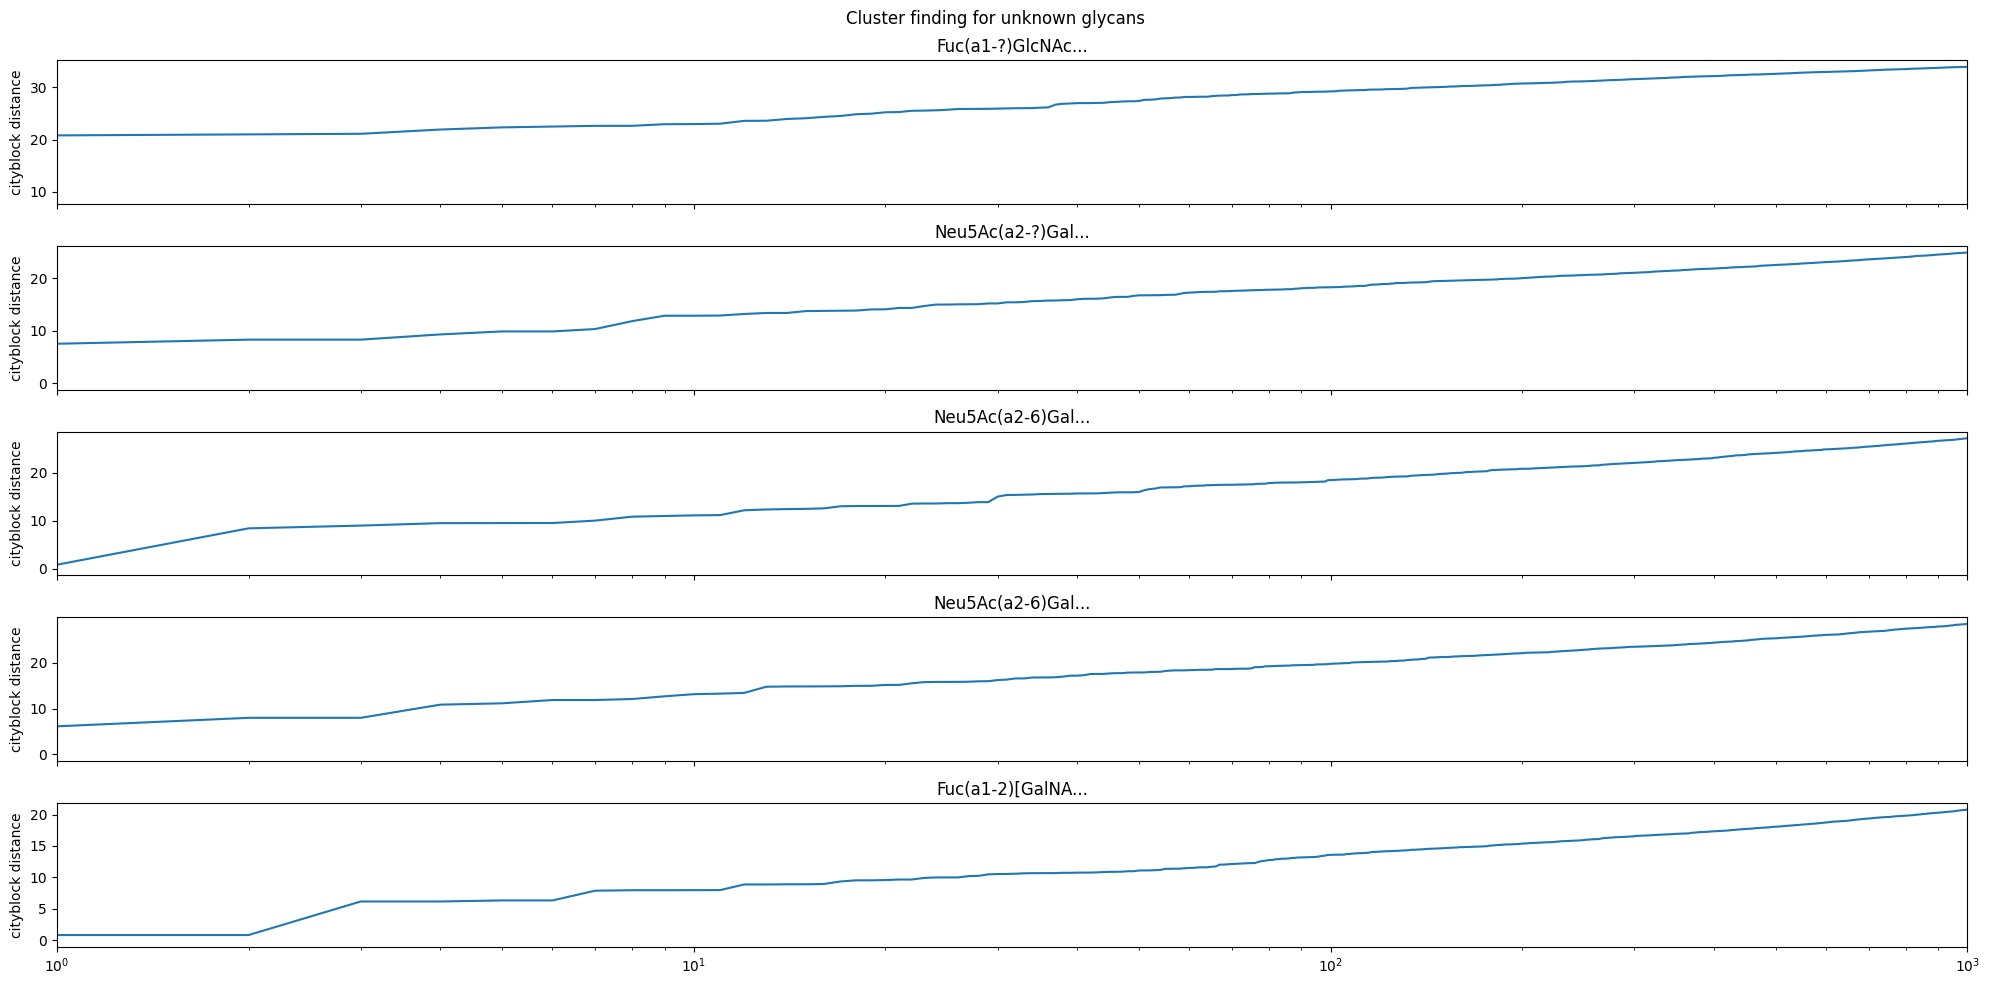

In [157]:
_ = plot_neighbours_distance(df_reps, df_glycan_list, metric='cityblock', log_scale=True)

### 2.4.2 Find clusters

https://www.datacamp.com/tutorial/dbscan-clustering-algorithm

In [80]:
# All glycan data embeddings
X = df_reps.T

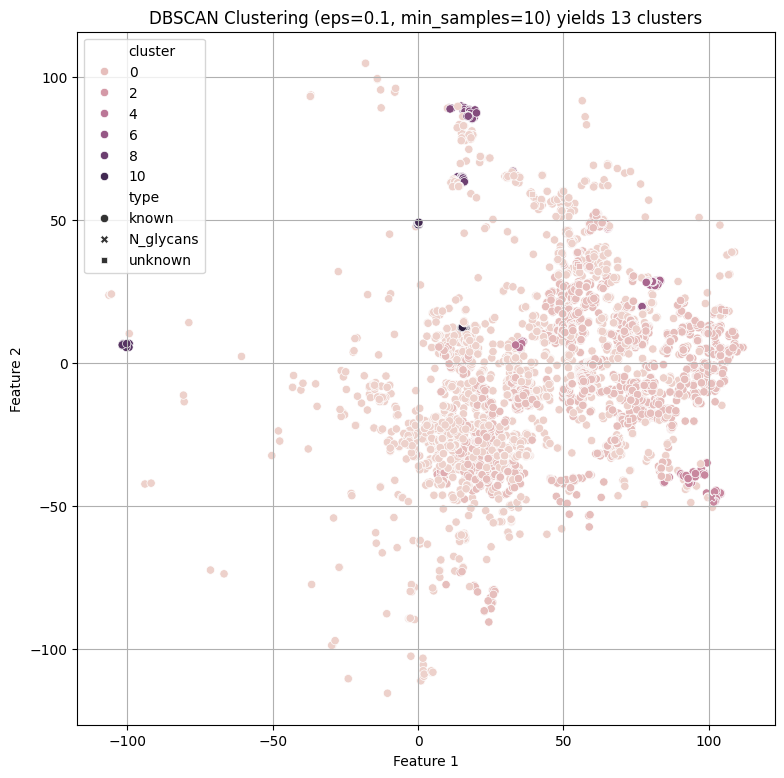

In [85]:
# Run DBSCAN with the chosen epsilon value
def run_dbscan(df_data, embed, eps, min_samples, label='type', metric='cosine'):
    """
    Runs DBSCAN and visualizes the clusters.
    Args:
        df_data (pd DataFrame): Data embeddings to cluster with data points name in index.
        embed (pd DataFrame): Data visualisation embeddings and labels with data points name in index.
        eps (float): Epsilon parameter for DBSCAN.
        min_samples (int): Minimum number of samples for a cluster.
    """
    assert((df_data.shape[0] == embed.shape[0])) # check for consistency in number of sample
    assert(len(set(df_data.index) - set(embed.index)) == 0) # check for consistency in index
    assert(label in embed.columns)

    # Cluster the data
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
    labels = dbscan.fit_predict(df_data.to_numpy())

    # Visualize the clustering
    augm_embed = embed.loc[df_data.index] # make sure that it is equally ordered
    augm_embed['cluster'] = labels

    plt.figure(figsize = (9, 9))
    sns.scatterplot(data=augm_embed, x=0, y=1, hue='cluster', style=label)
    # plt.scatter(tsne_embed[0], tsne_embed[1], c=labels, cmap='Paired', s = 40, alpha = 0.8, marker='+')
    # plt.scatter(tsne_embed_spec[0], tsne_embed_spec[1], marker='^', color='black', s=60, label='Unknown glycans')
    # plt.scatter(tsne_embed_N[0], tsne_embed_N[1], marker='d', color='red', s=60, label='N glycans')

    plt.title(f"DBSCAN Clustering (eps={eps}, min_samples={min_samples}) yields {len(np.unique(labels))} clusters")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.legend()
    plt.grid()
    plt.show()

run_dbscan(X, tsne_emb_1[tsne_emb_1['from_human'] == 'Human glycan'], eps=0.1, min_samples=10)

### 2.4.3 Analyse neighbours

In [99]:
df_data.columns

Index(['glycan', 'Species', 'Genus', 'Family', 'Order', 'Class', 'Phylum',
       'Kingdom', 'Domain', 'ref', 'glytoucan_id', 'glycan_type',
       'disease_association', 'disease_id', 'disease_sample',
       'disease_direction', 'disease_ref', 'disease_species', 'tissue_sample',
       'tissue_id', 'tissue_ref', 'tissue_species', 'Composition'],
      dtype='object')

In [ ]:
metadata = ['glycan', 'Species', 'glycan_type',\
                      'disease_association', 'tissue_sample',\
                      'disease_species']

def glycan_information(glycan, neighbours, df_metadata, metadata, df_proteins_binding):

  assert(isinstance(glycan), str)
  assert(isinstance(neighbours), list)
  assert(isinstance(df_metadata, pd.DataFrame))
  assert(isinstance(metadata, list))
  assert(isinstance(df_proteins_binding, pd.DataFrame))

  neighbours_metadata = pd.DataFrame(neighbours, columns=['glycan'])
  neighbours_metadata = neighbours_metadata.merge(df_metadata[metadata],\
                                                  on='glycan', how='left')\
                                           .drop('glycan', axis=1)

  print(f"For glycan {glycan} and its {len(neighbours)} neighbours:\n", "*"*60, "\n")
  for c in neighbours_metadata.columns:
    d = neighbours_metadata[c].dropna().explode(c).values_count()
    print(f"{c}:", "\n", d, "\n")

  # Find neighbouring glycans for which we have protein binding data
  glycans_binding = list(set(neighbours).intersection(set(df_proteins_binding.columns)))
  for g in glycans_binding:
    df_proteins_binding[~df_proteins_binding[g].isna()].set_index('protein').index





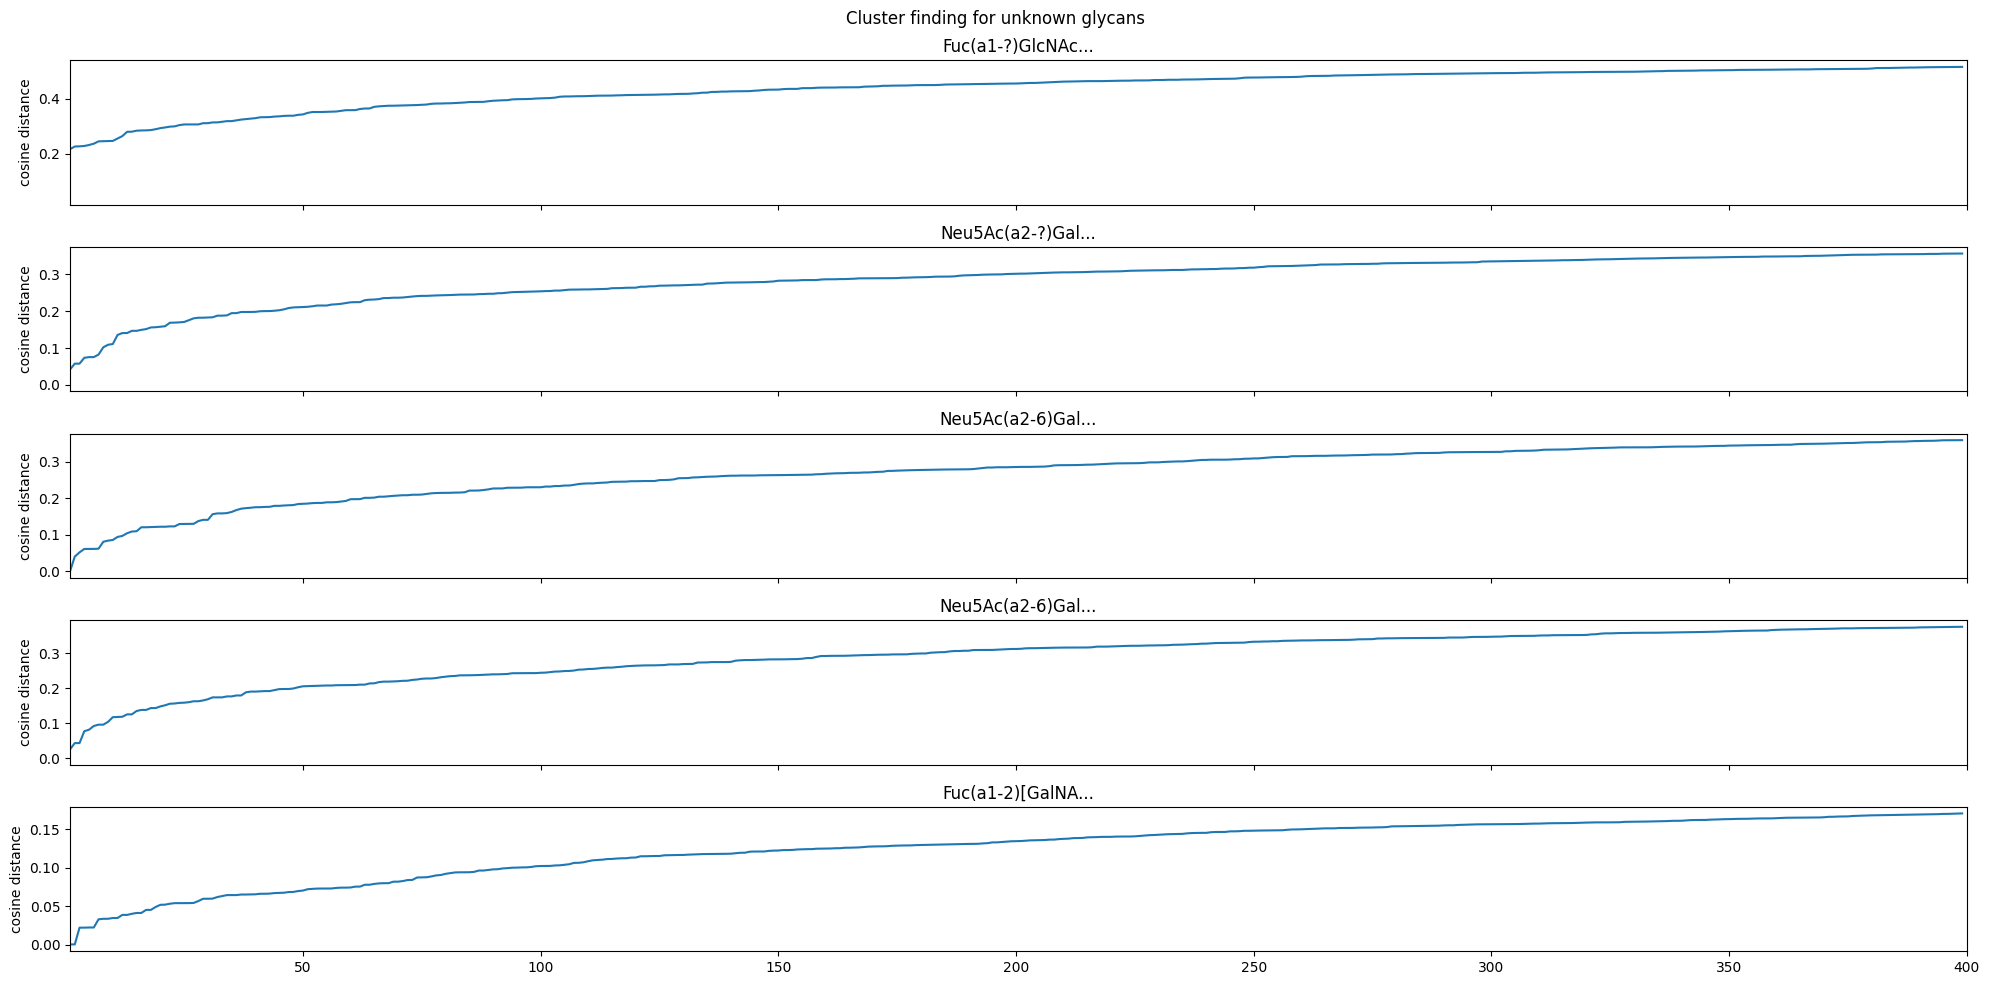

In [141]:
cosine_10th_neighbours = plot_neighbours_distance(df_reps, df_glycan_list, max_dist=400, n_closest=10, metric='cosine')

In [121]:
# def print_neighbours_chars(df_neighbours, df_metadata, glycan_of_interest):

meta_data = df_data[df_data['Species'] == 'Homo_sapiens']\
                    [['glycan', 'Species', 'glycan_type',\
                      'disease_association', 'tissue_sample',\
                      'disease_species']]
df_info = cosine_10th_neighbours.merge(meta_data,\
                              left_on=cosine_10th_neighbours.columns[3],\
                              right_on='glycan')\
                      .drop([c for c in cosine_10th_neighbours.columns if c != cosine_10th_neighbours.columns[3]], axis=1)
df_info.head()

,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[GlcNAc(b1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)GlcNAc,glycan,Species,glycan_type,disease_association,tissue_sample,disease_species
0,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[Glc...,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[Glc...,Homo_sapiens,N,"[colorectal_cancer, colorectal_cancer, colorec...","[2A3_cell_line, Cal-27_cell_line, FaDu_cell_li...","[Homo_sapiens, Homo_sapiens, Homo_sapiens]"
1,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Man...,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Man...,Homo_sapiens,N,[],[],[]
2,Man(a1-3)[Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-2)Man...,Man(a1-3)[Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-2)Man...,Homo_sapiens,N,[],[urine],[]
3,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[Gal...,Neu5Ac(a2-6)Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[Gal...,Homo_sapiens,N,[],"[2A3_cell_line, Cal-27_cell_line, FaDu_cell_li...",[]
4,Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[Neu5Ac(a2-6)Gal...,Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[Neu5Ac(a2-6)Gal...,Homo_sapiens,N,[],[],[]


In [152]:
meta_data = df_data[['glycan', 'Species', 'glycan_type',\
                      'disease_association', 'tissue_sample',\
                      'disease_species']]
df_info = cosine_10th_neighbours.merge(meta_data,\
                              left_on=cosine_10th_neighbours.columns[4],\
                              right_on='glycan')\
                      .drop([c for c in cosine_10th_neighbours.columns if c != cosine_10th_neighbours.columns[4]], axis=1)
df_info.head(10)

,Fuc(a1-2)[GalNAc(a1-3)]Gal(b1-4)GlcNAc(b1-2)Man(a1-6)[Gal(b1-4)GlcNAc(b1-2)Man(a1-3)]Man(b1-4)GlcNAc(b1-4)GlcNAc,glycan,Species,glycan_type,disease_association,tissue_sample,disease_species
0,Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)[GalNA...,Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)[GalNA...,NaN,N,[],[],[]
1,GalNAc(a1-3)[Fuc(a1-2)]Gal(b1-4)GlcNAc(b1-2)Ma...,GalNAc(a1-3)[Fuc(a1-2)]Gal(b1-4)GlcNAc(b1-2)Ma...,NaN,N,[],[],[]
2,Fuc(a1-2)[GalNAc(a1-3)]Gal(b1-4)GlcNAc(b1-2)Ma...,Fuc(a1-2)[GalNAc(a1-3)]Gal(b1-4)GlcNAc(b1-2)Ma...,Homo_sapiens,N,[],[plasma],[]
3,Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)[GalNA...,Gal(b1-4)GlcNAc(b1-2)Man(a1-3)[Fuc(a1-2)[GalNA...,NaN,N,[],[],[]
4,Fuc(a1-2)[GalNAc(a1-3)]Gal(b1-4)GlcNAc(b1-2)Ma...,Fuc(a1-2)[GalNAc(a1-3)]Gal(b1-4)GlcNAc(b1-2)Ma...,Homo_sapiens,N,[],"[mammalian_vulva, plasma]",[]
5,Fuc(a1-2)[GalNAc(a1-3)]Gal(b1-4)GlcNAc(b1-2)Ma...,Fuc(a1-2)[GalNAc(a1-3)]Gal(b1-4)GlcNAc(b1-2)Ma...,Homo_sapiens,N,[],"[mammalian_vulva, pancreas, plasma]",[]
6,GalNAc(a1-3)[Fuc(a1-2)]Gal(b1-4)GlcNAc(b1-2)Ma...,GalNAc(a1-3)[Fuc(a1-2)]Gal(b1-4)GlcNAc(b1-2)Ma...,NaN,N,[],[],[]
7,Fuc(a1-2)[GalNAc(a1-3)]Gal(b1-4)GlcNAc(b1-2)Ma...,Fuc(a1-2)[GalNAc(a1-3)]Gal(b1-4)GlcNAc(b1-2)Ma...,Homo_sapiens,N,[],[erythrocyte],[]
8,GalNAc(a1-3)[Fuc(a1-2)]Gal(b1-4)GlcNAc(b1-2)Ma...,GalNAc(a1-3)[Fuc(a1-2)]Gal(b1-4)GlcNAc(b1-2)Ma...,NaN,N,[],[],[]
9,Fuc(a1-2)[GalNAc(a1-3)]Gal(b1-4)GlcNAc(b1-2)Ma...,Fuc(a1-2)[GalNAc(a1-3)]Gal(b1-4)GlcNAc(b1-2)Ma...,Homo_sapiens,N,[],[pancreas],[]


In [132]:
for g in df_info['glycan'].values:
  if g in glycan_binding.columns:
    print(glycan_binding[~glycan_binding[g].isna()].set_index('protein').index)

Index(['TAL6-4LysM', 'rCnSL-proA', 'AntigenI/IIA3VP1', 'TAL6-6LysM',
       'SP15308A-bot-339-19-339', 'VLRB.aGPA.23-GCN4-biotin',
       'Protein L(A-C2)', 'A/H16-2', 'A/H16',
       'A/Gull/Maryland/704/1977(H13N6)',
       ...
       'LTL', 'PX14367A-bth-493-35-493', 'PX9961M-bvu-482-23-482', '4F2hc',
       'Odorranalectin', 'tcdB-B2-1', 'Gal_3C', 'cov/mhv/MERS', 'Vd2LysM',
       'cov/MERS'],
      dtype='object', name='protein', length=1118)
Index(['TAL6-4LysM', 'rCnSL-proA', 'AntigenI/IIA3VP1', 'TAL6-6LysM',
       'SP15308A-bot-339-19-339', 'VLRB.aGPA.23-GCN4-biotin',
       'Protein L(A-C2)', 'A/H16-2', 'A/H16',
       'A/Gull/Maryland/704/1977(H13N6)',
       ...
       'A/BCM/1/1980(H3N2)', 'LTL', 'PX14367A-bth-493-35-493',
       'PX9961M-bvu-482-23-482', '4F2hc', 'Odorranalectin', 'Gal_3C',
       'cov/mhv/MERS', 'Vd2LysM', 'cov/MERS'],
      dtype='object', name='protein', length=1072)
Index(['TAL6-4LysM', 'rCnSL-proA', 'AntigenI/IIA3VP1', 'TAL6-6LysM',
       'SP15308A-b

## 2.4 Use pre-trained embedding to compare with our embedding

In [ ]:
model_pret = prep_model(model_type = 'SweetNet', num_classes=1011, trained=True)

In [ ]:
from glycowork.motif.analysis import plot_embeddings


embds = glycans_to_emb(glycans['glycan'].values.tolist(), model_pret, class_list=class_list)

In [ ]:
df_learned_rep_augm_2 = embds.merge(glycans, left_index=True, right_index=True)
tsne_emb_2 = TSNE(random_state = 42).fit_transform(df_learned_rep_augm_2.drop(['glycan', 'type', 'tissue_sample', 'Species', 'Composition'], axis=1))

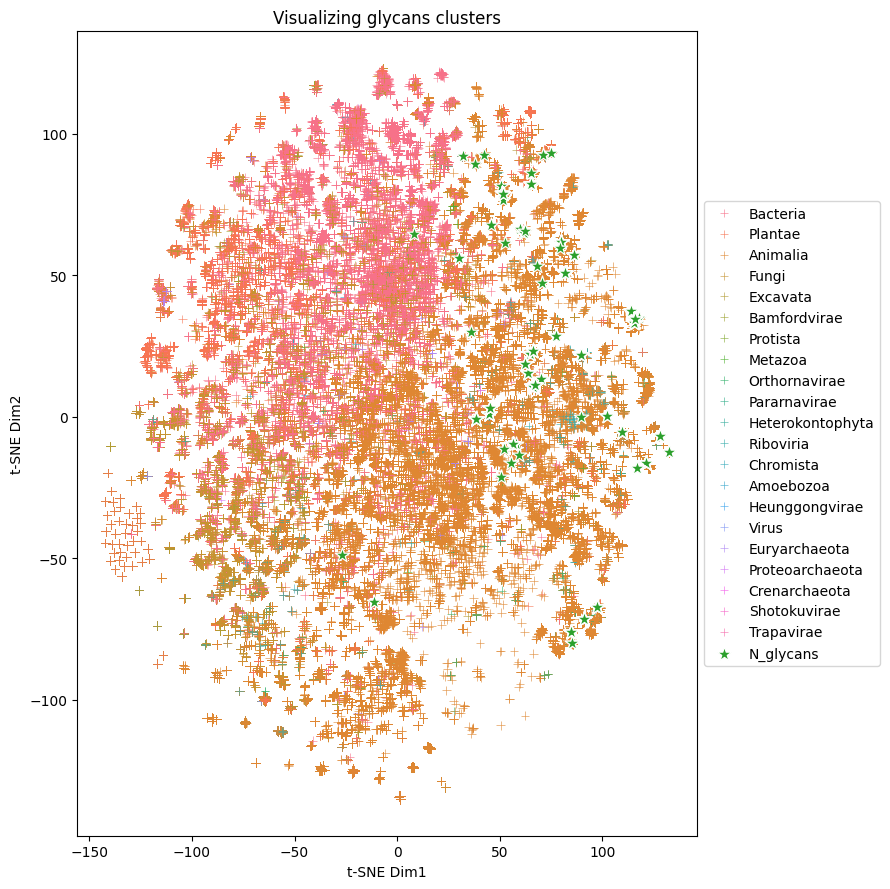

In [ ]:
df_plot = pd.DataFrame(tsne_emb_2).merge(glycans, left_index=True, right_index=True)\
                                  .merge(df_data[['glycan', 'Kingdom']].explode('Kingdom'), on='glycan')
df_plot['from_human'] = df_plot['Species'] == 'Homo_sapiens'
plt.figure(figsize = (9, 9))
custom_colors = {'unknown': 'red', 'known':'black', 'N_glycans':'blue' }
custom_markers = {'unknown': 'X', 'known':'^', 'N_glycans':'*' }
sns.scatterplot(data = df_plot[df_plot['type'] == 'known'], x =0 , y = 1,\
                s = 40, alpha = 0.8, hue='Kingdom', marker='+')
sns.scatterplot(data = df_plot[df_plot['type'] == 'unknown'], x =0 , y = 1,\
                s = 30, alpha = 1,palette = ['black'], marker='o', label='unknown')
sns.scatterplot(data = df_plot[df_plot['type'] == 'N_glycans'], x =0 , y = 1,\
                s = 120, alpha = 1,palette = ['green'], marker='*', label='N_glycans')
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.xlabel('t-SNE Dim1')
plt.ylabel('t-SNE Dim2')
plt.title('Visualizing glycans clusters')
plt.tight_layout()

We can see that N glycans form tigher clusters.